In [1]:
import numpy as np
import scipy.sparse.linalg

import utils

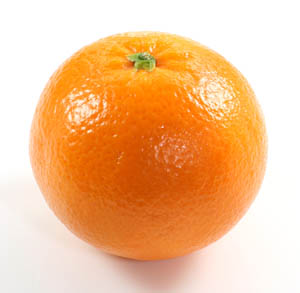

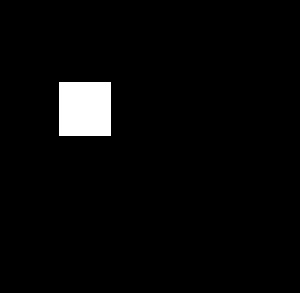

In [2]:
folder_path = "img/archive (1)/"

source = utils.open_and_print_image(folder_path + "source_light")

mask = utils.open_and_print_image(folder_path + "mask_light", is_mask=True)

In [3]:
height, width, mask, inner_mask, boundary_mask, pixel_ids, inner_ids, boundary_ids, mask_ids, inner_pos, boundary_pos, mask_pos = utils.setup_variables(mask)
channels = 3


In [4]:
A = utils.create_matrix_A(mask_ids, inner_ids, boundary_ids, inner_pos, boundary_pos, width)

In [5]:
def compute_gradients(src):
    # compute gradients 
    I_x, I_y = utils.compute_gradient(src)
    # compute gradient norm
    I = np.sqrt(I_x**2 + I_y**2) 
    # compute alpha and beta
    alpha = 0.2 * I.mean()
    beta = 0.2
    # compute the transformation and the backward gradients
    I_xx, _ = utils.compute_gradient(np.power(alpha, beta) * np.power(I + 1e-8, -beta) * I_x, forward=False)
    _, I_yy = utils.compute_gradient(np.power(alpha, beta) * np.power(I + 1e-8, -beta) * I_y, forward=False)
    return I_xx + I_yy

In [6]:
def poisson_illum_change_channel(src):
    # change to the log domain
    log_src = np.log(src + 1e-8)
    log_gradients = compute_gradients(log_src)

    boundary_pixel_values = utils.get_masked_values(log_src, boundary_mask).flatten()
    inner_gradient_values = utils.get_masked_values(log_gradients, inner_mask).flatten()

    # Construct b
    b = utils.construct_b(mask_ids, inner_pos, boundary_pos, inner_gradient_values, boundary_pixel_values)

    # Solve Ax = b
    x = scipy.sparse.linalg.spsolve(A, b)
    
    # reconstruct the new image (single channel)
    new_log_src = np.log(np.zeros_like(src).flatten() + 1e-8)
    new_log_src[mask_pos] = x
    # change back to the original domain
    new_src = np.exp(new_log_src.reshape(src.shape))
    
    img = utils.get_alpha_blended_img(new_src, src, mask)
    img = np.clip(img, 0, 1)

    return img

In [7]:
def poisson_illum_change():
    return np.dstack([poisson_illum_change_channel(source[..., i]) for i in range(source.shape[-1])])

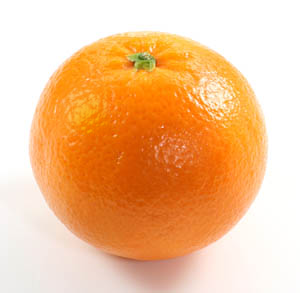

In [8]:
img = poisson_illum_change()

utils.save_and_print(img, folder_path, "result.png")